# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda).

Your organization has asked you to explore and answer some questions from the data collected. See the project instructions.

In [66]:
# Import packages
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")

# EDA
print(drug_safety.info())
drug_safety.sample(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              16103 non-null  int64  
 1   sex              16103 non-null  object 
 2   trx              16103 non-null  object 
 3   week             16103 non-null  int64  
 4   wbc              9128 non-null   float64
 5   rbc              9127 non-null   float64
 6   adverse_effects  16103 non-null  object 
 7   num_effects      16103 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1006.6+ KB
None


,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
3428,65,male,Placebo,1,NaN,NaN,No,0
12849,56,male,Drug,8,NaN,NaN,No,0
13296,77,male,Drug,4,5.9,4.1,No,0
199,76,male,Drug,2,13.2,4.3,No,0
1266,65,male,Drug,2,6.5,4.7,No,0
6055,75,male,Placebo,12,6.1,4.5,No,0
15429,43,female,Drug,4,9.4,4.5,No,0
2966,62,male,Placebo,8,8.7,4.9,No,0
15765,55,male,Drug,4,9.1,5.1,No,0
5288,77,male,Placebo,4,7.9,4.6,No,0


In [67]:
# defined confidence level
confidence_level = 0.95
alpha = 1 - confidence_level

In [68]:
#-- Determine if the proportion of adverse effects 
#-- differs significantly between the Drug and Placebo groups

# control/treatment split
drug_adverse_eff = drug_safety[drug_safety['trx'] == 'Drug']['adverse_effects'] == 'Yes'
placebo_adverse_eff = drug_safety[drug_safety['trx'] == 'Placebo']['adverse_effects'] == 'Yes'
# counting and performing z-test
with_effect = [drug_adverse_eff.sum(), placebo_adverse_eff.sum()]
nobs = [drug_adverse_eff.count(), placebo_adverse_eff.count()]
stat, two_sample_p_value = proportions_ztest(count=with_effect, nobs=nobs, alternative='two-sided')
# print out
print('The proportion of adverse effects:')
print('Drug (treatment): ', with_effect[0]/nobs[0])
print('Placebo (control): ', with_effect[1]/nobs[1])
print("Result of proportions z-test:")
print('p-value = ', two_sample_p_value)
print('alpha = ', alpha)

The proportion of adverse effects:
Drug (treatment):  0.09546005406917125
Placebo (control):  0.09523809523809523
Result of proportions z-test:
p-value =  0.9639333330262475
alpha =  0.050000000000000044


In [69]:
#-- Find out if the number of adverse effects is independent of the treatment and control groups

# Use Chi-Square Test to test the independence of the two variables 
expected, observed, stats = pingouin.chi2_independence(data=drug_safety, x='trx', y='num_effects')
print(observed)
print(stats)
# The conditions of Pearson chi2 test are satisfied ->> Take the Pearson's test result
num_effects_p_value = float(stats['pval'][stats['test']=='pearson'])
print("Pearson p-value: ", num_effects_p_value)

num_effects     0    1   2  3
trx                          
Drug         9703  956  63  5
Placebo      4864  486  25  1
                 test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  1.799644  3.0  0.615012  0.010572  0.176275
1        cressie-read  0.666667  1.836006  3.0  0.607131  0.010678  0.179153
2      log-likelihood  0.000000  1.922495  3.0  0.588648  0.010926  0.186033
3       freeman-tukey -0.500000  2.001752  3.0  0.572043  0.011149  0.192379
4  mod-log-likelihood -1.000000  2.096158  3.0  0.552690  0.011409  0.199984
5              neyman -2.000000  2.344303  3.0  0.504087  0.012066  0.220189
Pearson p-value:  0.6150123339426765


array([<AxesSubplot: title={'center': 'Drug'}>,
       <AxesSubplot: title={'center': 'Placebo'}>], dtype=object)

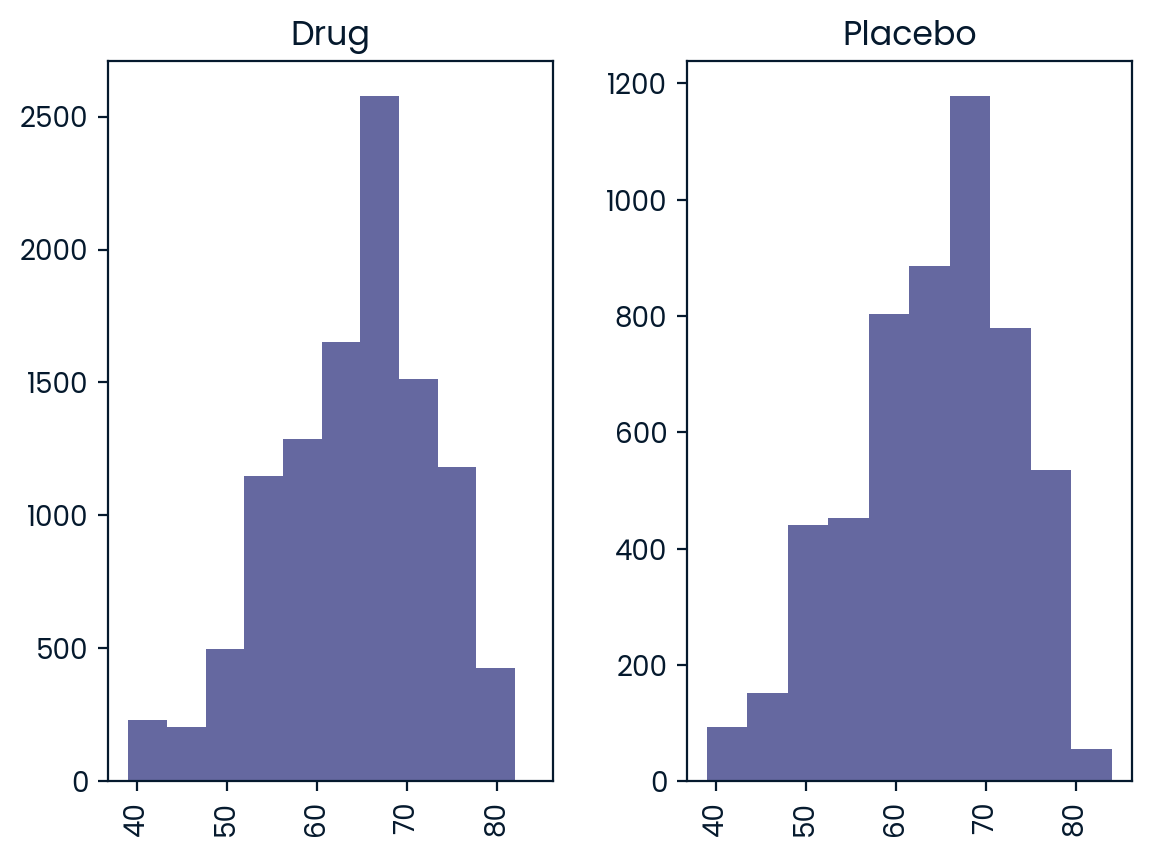

In [70]:
#-- Examine if there is a significant difference between the ages of the Drug and Placebo groups
#-- plot histogram
drug_safety.hist(column='age',by='trx',bins=10,sharex=True)

In [71]:
# test the normality
res = pingouin.normality(data=drug_safety, dv='age', group='trx')
if sum(res['pval'] < alpha) > 0:
    print('At least one distribution is not normal!')
else:
    print('Two distributions are normal!')

At least one distribution is not normal!


Since the distributions are not normal, but are quite similar (by eye-balling), I use the Mann–Whitney U test instead of ttest for examining if there is a significant difference between the ages of the Drug and Placebo groups.

In [72]:
group_drug = drug_safety.loc[drug_safety['trx']=='Drug', 'age']
group_placebo = drug_safety.loc[drug_safety['trx']=='Placebo', 'age']
result = pingouin.mwu(x=group_drug, y=group_placebo)
age_group_effects_p_value = float(result['p-val'])
print('p-value from the Mann–Whitney U test:')
print(age_group_effects_p_value)

p-value from the Mann–Whitney U test:
0.25696267004066287
